# Get and save median data of HL60 + LatB from new experiments with measurement for strain correction
Update Nov 2023: Add more strain features derived from inertia ratio

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=0.8)
from tqdm.notebook import tqdm

from scripts.stress_hyper import (shear_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  normal_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  total_stress_hyper_wc60_lc500_net_strain_ir_20240226
                                  )

In [2]:
print("numpy v{}".format(np.__version__))
import matplotlib
print("matplotlib v{}".format(matplotlib.__version__))
print("pandas v{}".format(pd.__version__))
print("seaborn v{}".format(sns.__version__))
import lmfit
print("lmfit v{}".format(lmfit.__version__))

numpy v1.25.2
matplotlib v3.7.1
pandas v2.0.3
seaborn v0.12.2
lmfit v1.2.2


Versions 20231114:
```
numpy v1.25.2
matplotlib v3.7.1
pandas v2.0.3
seaborn v0.12.2
lmfit v1.2.2
```

In [3]:
# location of all data exports
data_exports = "..\\data_exports"

In [4]:
def get_df_strain_features(df_in):
    df_in['strain_inert'] = df_in['inert_ratio_raw'] - 1
    # net tensile strain based on inertia ratio assuming shape is an ellipse
    df_in['net_strain_inert'] = ((df_in['inert_ratio_raw'] - 1)
                                 / np.sqrt(df_in['inert_ratio_raw']))
    # strain features based on principal inertia ratio
    df_in['strain_inert_prnc'] = df_in['inert_ratio_prnc'] - 1
    # net tensile strain based on inertia ratio assuming shape is an ellipse
    df_in['net_strain_inert_prnc'] = ((df_in['inert_ratio_prnc'] - 1)
                                      / np.sqrt(df_in['inert_ratio_prnc']))
    df_in['taylor_strain_ir'] = ((df_in['inert_ratio_raw'] - 1)
                                 / (df_in['inert_ratio_raw'] + 1))
    # ellipse features
    df_in['net_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                               / np.sqrt(df_in['ell_major'] * df_in['ell_minor']))
    df_in['taylor_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                                  / (df_in['ell_major'] + df_in['ell_minor']))
    df_in['aspect_ell'] = df_in['ell_major'] / df_in['ell_minor']
    return df_in


## Read in inlet data for all measurements

In [5]:
print("Reading in data 20230912")
path_20230912_inlet = os.path.join(data_exports,
                                   "20230912_HL60_LatB",
                                   "20230913_hl60_latb_inlet.tsv")
df_20230912_inlet = pd.read_csv(path_20230912_inlet, sep='\t', index_col=0)

print("Reading in data 20230914")
path_20230914_inlet = os.path.join(data_exports,
                             "20230914_HL60_LatB",
                             "20230915_hl60_latb_inlet.tsv")
df_20230914_inlet = pd.read_csv(path_20230914_inlet, sep='\t', index_col=0)

print("Reading in data 20230919")
path_20230919_inlet = os.path.join(data_exports,
                                   "20230919_HL60_LatB",
                                   "20230919_hl60_latb_inlet.tsv")
df_20230919_inlet = pd.read_csv(path_20230919_inlet, sep='\t', index_col=0)

print("Done")

Reading in data 20230912
Reading in data 20230914
Reading in data 20230919
Done


In [6]:
df_inlet_all = pd.concat([df_20230912_inlet,
                          df_20230914_inlet,
                          df_20230919_inlet
                          ], ignore_index=True)
df_inlet_all = get_df_strain_features(df_inlet_all)

##### Cut data into bins

In [7]:
x_feat = 'pos_x'
n_bins = 120
# need to iterate over all dates, concentrations
# to create bins then concatenate to big dataframe again
df_median_inlet = pd.DataFrame()
dates = df_inlet_all['date'].unique()
for date in dates:
    df_date = df_inlet_all.loc[df_inlet_all['date'] == date]
    for concentration in df_date['LatB concentration'].unique():
        df_cc = df_date.loc[df_date['LatB concentration'] == concentration]
        bins = pd.cut(df_cc[x_feat], n_bins)
        df_grouped = df_cc.groupby(by=['LatB concentration', bins],
                                   as_index=False
                                   )
        df_median_inlet = pd.concat([df_median_inlet, df_grouped.median()], ignore_index=True)
df_median_inlet.reset_index(inplace=True, drop=True)

In [8]:
df_median_inlet

LatB concentration  area_msd  area_ratio     area_um    aspect  \
0                    0.1    271.50    1.033608  131.321610  1.000000   
1                    0.1    297.75    1.031050  141.610005  1.000000   
2                    0.1    277.00    1.034364  132.940000  1.000000   
3                    0.1    301.00    1.030723  143.806410  1.000000   
4                    0.1    277.00    1.033285  131.090410  1.000000   
...                  ...       ...         ...         ...       ...   
3235                 0.0    305.50    1.032648  144.962400  1.000000   
3236                 0.0    282.00    1.034286  135.020810  1.000000   
3237                 0.0    293.50    1.029972  140.222810  1.045454   
3238                 0.0    283.50    1.032593  135.714400  1.000000   
3239                 0.0    282.25    1.031982  134.211600  1.020833   

      bright_avg  bright_sd      circ    deform  ell_angle  ...    wc  \
0     118.761035  26.686449  0.986498  0.013502   1.596797  ...  60.0   
1     118.603455  26.855004  0.987161  0.012839   1.446725  ...  60.0   
2     118.670410  26.900627  0.986398  0.013602   1.554527  ...  60.0   
3     118.403030  26.747519  0.986209  0.013791   1.399719  ...  60.0   
4     118.481480  26.816890  0.986368  0.013632   1.380192  ...  60.0   
...          ...        ...       ...       ...        ...  ...   ...   
3235  135.329240  26.370987  0.987328  0.012672   1.559874  ...  60.0   
3236  135.051730  28.121560  0.987112  0.012888   1.040872  ...  60.0   
3237  135.433880  28.463772  0.987770  0.012230   1.982741  ...  60.0   
3238  135.370530  28.344326  0.987557  0.012443   0.810904  ...  60.0   
3239  135.974685  27.173527  0.986531  0.013469   1.929424  ...  60.0   

      strain_inert  net_strain_ell  taylor_strain_ell  time_hyper_region  \
0         0.009428        0.053374           0.026677                NaN   
1        -0.001295        0.050297           0.025140                NaN   
2         0.002641        0.058374           0.029175                NaN   
3        -0.003497        0.050842           0.025413                NaN   
4         0.006664        0.055771           0.027875                NaN   
...            ...             ...                ...                ...   
3235      0.005681        0.057908           0.028942                NaN   
3236      0.028426        0.061844           0.030907                NaN   
3237      0.032100        0.060995           0.030483                NaN   
3238      0.021541        0.061120           0.030546                NaN   
3239      0.029751        0.058053           0.029014                NaN   

      net_strain_inert  strain_inert_prnc  net_strain_inert_prnc  \
0             0.009384           0.053736               0.052348   
1            -0.001296           0.046350               0.045311   
2             0.002637           0.051026               0.049772   
3            -0.003503           0.050995               0.049742   
4             0.006642           0.056309               0.054788   
...                ...                ...                    ...   
3235          0.005665           0.053419               0.052047   
3236          0.028030           0.062431               0.060569   
3237          0.031597           0.061497               0.059689   
3238          0.021313           0.064673               0.062678   
3239          0.029316           0.058054               0.056439   

      taylor_strain_ir  aspect_ell  
0             0.004692    1.054818  
1            -0.000648    1.051580  
2             0.001319    1.060103  
3            -0.001751    1.052151  
4             0.003321    1.057348  
...                ...         ...  
3235          0.002832    1.059609  
3236          0.014014    1.063786  
3237          0.015796    1.062883  
3238          0.010656    1.063016  
3239          0.014657    1.059762  

[3240 rows x 56 columns]

##### Fit quadratic function to net tensile strain from inertia ratio data

In [19]:
strain_feat = 'net_strain_inert'
fit_feat = 'net_strain_inert_fit'

In [21]:
net_strain_ir_polys = {}

df_median_inlet[fit_feat] = np.nan

for date in dates:
    df_date = df_median_inlet[df_median_inlet['date'] == date].copy()
    for concentration in df_date['LatB concentration'].unique():
        idx = ((df_median_inlet['date'] == date)
               & (df_median_inlet['LatB concentration'] == concentration))
        df_cc = df_median_inlet.loc[idx]
        x = df_cc['pos_x'].to_numpy()
        y = df_cc[strain_feat].to_numpy()
    
        # remove nans
        non_nan = ~(np.isnan(x) | np.isnan(y))
        x_nonan = x[non_nan]
        y_nonan = y[non_nan]
    
        model = lmfit.models.QuadraticModel()
        # use built-in default values for paras from lmfit
        paras = model.guess(y_nonan, x=x_nonan)
        result = model.fit(y_nonan, paras, x=x_nonan)
    
        key = f"{date}_{concentration}"
        net_strain_ir_polys[key] = result.params
        
        df_median_inlet[fit_feat][idx] = model.eval(result.params, x=x)

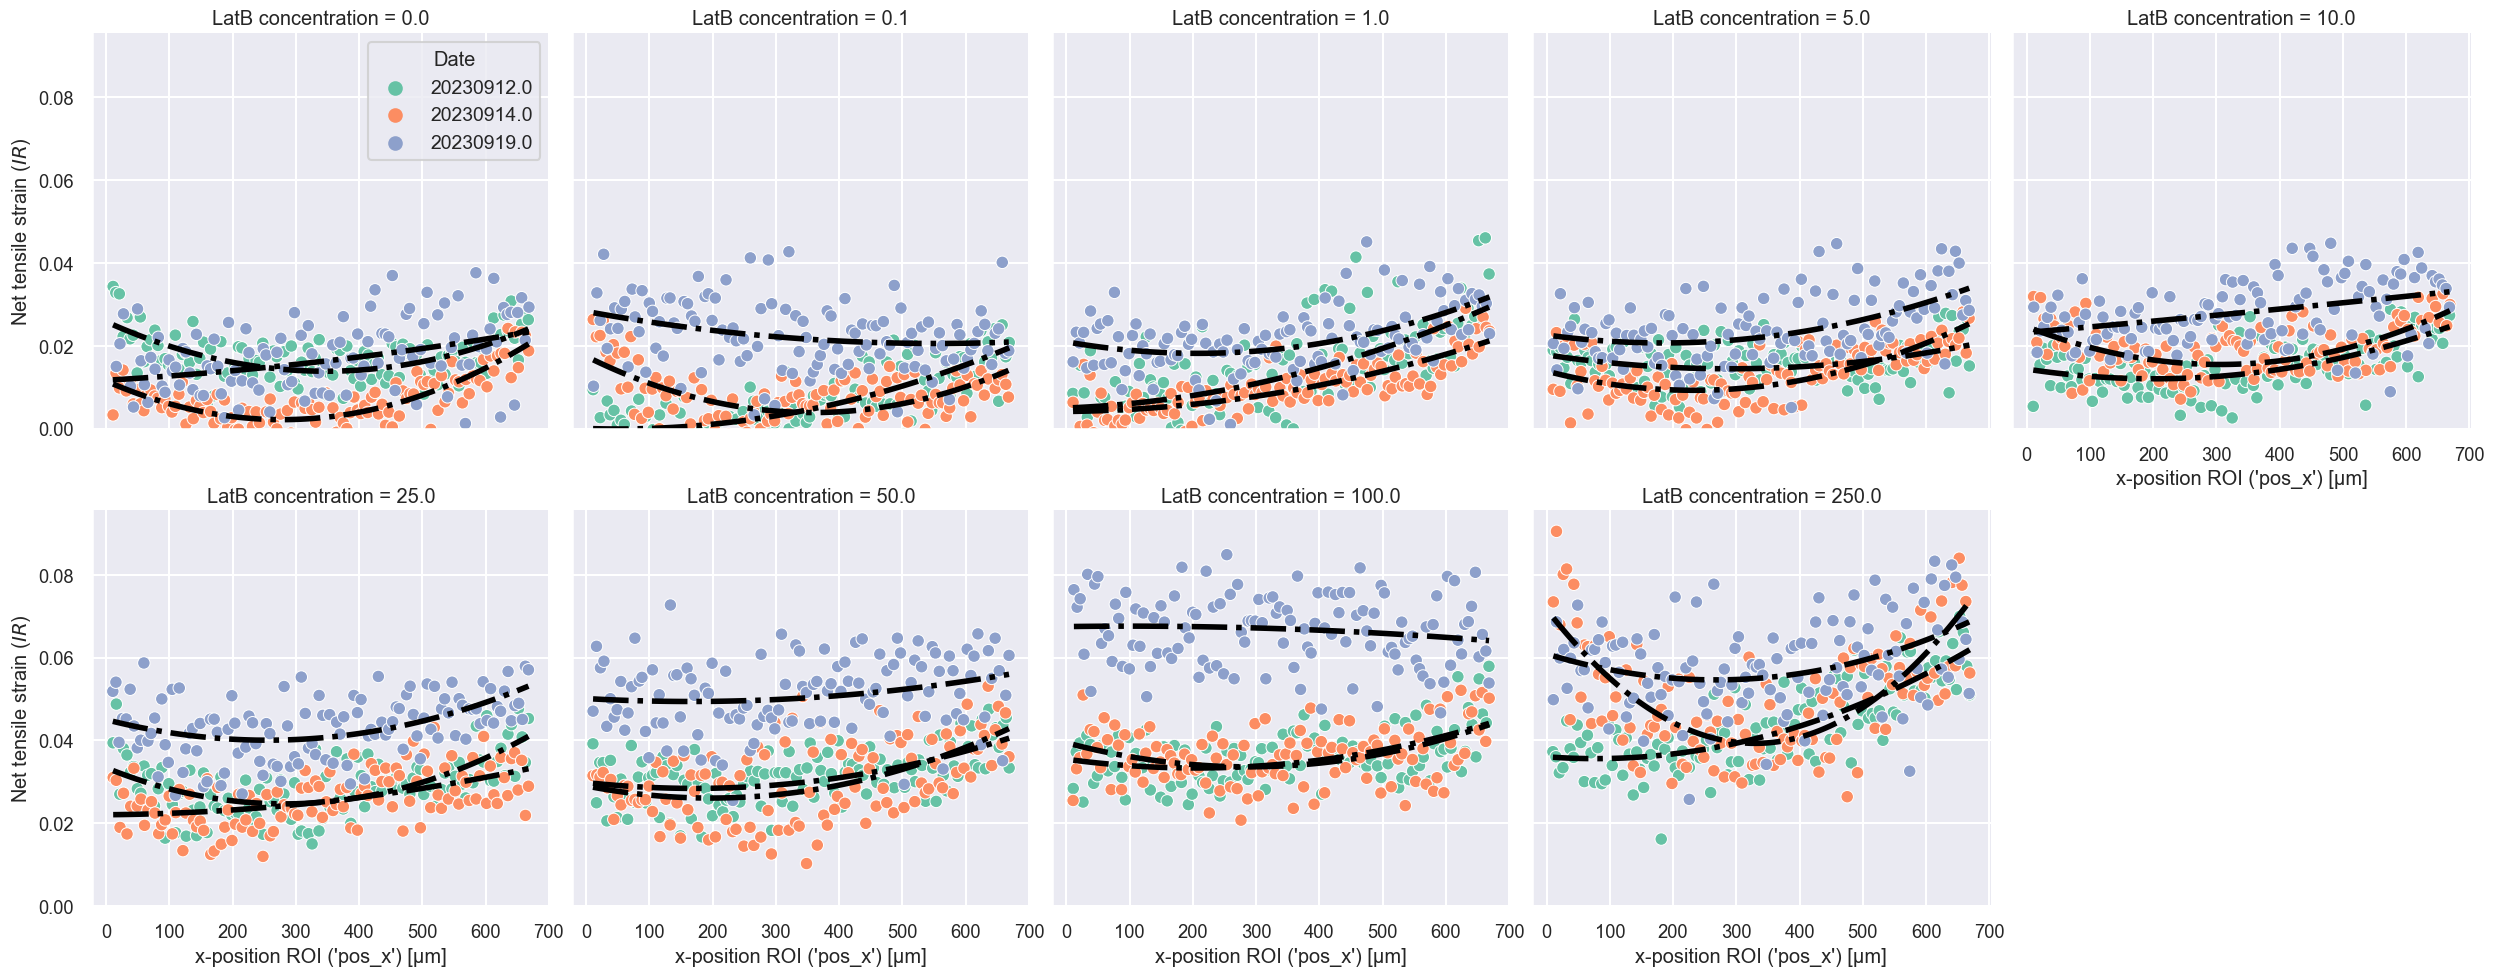

In [22]:
g = sns.relplot(data=df_median_inlet, x='pos_x', y=strain_feat,
                hue='date', palette='Set2',
                col='LatB concentration', col_wrap=5,
                aspect=1,
                kind='scatter',
                facet_kws={'legend_out': False})
g.set_xlabels("x-position ROI ('pos_x') [µm]")
g.set_ylabels("Net tensile strain ($IR$)")
g.axes[0].set_ylim(0)
g.axes[0].legend(ncol=1, title="Date", fontsize=14)

for date in dates:
    df_date = df_median_inlet[df_median_inlet['date'] == date].copy()
    concentrations = np.sort(df_date['LatB concentration'].unique())
    for ii, cc in enumerate(concentrations):
        ax = g.axes[ii]
        idx = df_date['LatB concentration'] == cc
        df = df_date.loc[idx]
    
        x = df['pos_x'].to_numpy()
        y = df[fit_feat].to_numpy()
        ii_sort = np.argsort(x)
        x = x[ii_sort]
        y = y[ii_sort]
        
        ax.plot(x, y, c='k', ls='-.', lw=4)

plt.show()

In [23]:
net_strain_ir_polys

{'20230912_0.1': Parameters([('a', <Parameter 'a', value=5.1176332724281834e-08 +/- 1.37e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-5.115474661515831e-06 +/- 9.58e-06, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=2.5708942104519423e-05 +/- 0.00141, bounds=[-inf:inf]>)]),
 '20230912_100.0': Parameters([('a', <Parameter 'a', value=5.024409419407754e-08 +/- 1.5e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-2.0625491468198017e-05 +/- 1.05e-05, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.03546196543555072 +/- 0.00154, bounds=[-inf:inf]>)]),
 '20230912_10.0': Parameters([('a', <Parameter 'a', value=5.7699802739288004e-08 +/- 1.29e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-2.3244664163086378e-05 +/- 9.06e-06, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.014359485670228956 +/- 0.00133, bounds=[-inf:inf]>)]),
 '20230912_1.0': Parameters([('a', <Parameter 'a', value=4.559133263810042e-08 +/- 2.32e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', va

## Read in hyper data for all measurements

In [29]:
x_0 = -50
x_max = 520

In [30]:
print("Reading in data 20230912")
path_20230912 = os.path.join(data_exports,
                             "20230912_HL60_LatB",
                             "20230913_hl60_latb_hyper.tsv")
df_20230912 = pd.read_csv(path_20230912, sep='\t', index_col=0)

print("Reading in data 20230914")
path_20230914 = os.path.join(data_exports,
                             "20230914_HL60_LatB",
                             "20230915_hl60_latb_hyper.tsv")
df_20230914 = pd.read_csv(path_20230914, sep='\t', index_col=0)

print("Reading in data 20230919")
path_20230919 = os.path.join(data_exports,
                             "20230919_HL60_LatB",
                             "20230919_hl60_latb_hyper.tsv")
df_20230919 = pd.read_csv(path_20230919, sep='\t', index_col=0)

print("Done")

Reading in data 20230912
Reading in data 20230914
Reading in data 20230919
Done


In [31]:
df_hl60_latb_all = pd.concat([df_20230912,
                              df_20230914,
                              df_20230919
                              ], ignore_index=True)

In [32]:
df_hl60_latb_all = get_df_strain_features(df_hl60_latb_all)

extension_rate = df_hl60_latb_all['extension_rate_fit']
pos_x = df_hl60_latb_all['x_hyper']
pix_size = 0.68
diameter = 2 * np.sqrt(pix_size**2 * df_hl60_latb_all['ell_major'] * df_hl60_latb_all['ell_minor'])
df_hl60_latb_all['diameter'] = diameter
flow_rate = df_hl60_latb_all['flow_rate']

df_hl60_latb_all['stress_net_ir'] \
    = total_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate,
                                                           pos_x,
                                                           diameter,
                                                           flow_rate)
df_hl60_latb_all['shear_stress_net_ir'] \
    = shear_stress_hyper_wc60_lc500_net_strain_ir_20240226(pos_x,
                                                           diameter,
                                                           flow_rate)
df_hl60_latb_all['normal_stress_net_ir'] \
    = normal_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate)

~~Export with new features (skip this in this notebook because the input files are alerady well summarized)~~

In [33]:
savepath = os.path.join(data_exports, "20231114_master_dataframe_HL60_LatB_all.tsv")

In [34]:
df_hl60_latb_all.to_csv(savepath, sep='\t')

#### Read data from export

In [35]:
# df_hl60_latb_all = pd.read_csv(savepath, sep='\t', index_col=0)

##### Filter the data

In [36]:
if 'Unnamed: 0' in df_hl60_latb_all.columns:
    df_hl60_latb_all.drop(columns=['Unnamed: 0'], inplace=True)
    
filter_idx = (df_hl60_latb_all['area_ratio'] < 1.05) \
             & (df_hl60_latb_all['aspect'] <= 2)
df_hl60_latb_all = df_hl60_latb_all.loc[filter_idx]

In [37]:
df_hl60_latb_all

area_msd  area_ratio     area_um    aspect  bright_avg  bright_sd  \
3           439.0    1.046697  212.472810  1.080000  128.669480  27.905672   
4           431.5    1.039397  207.386410  1.000000  128.019270  27.809263   
5           434.5    1.037975  208.542400  1.000000  128.561700  27.458275   
6           437.5    1.037714  209.929610  1.000000  126.321350  29.094988   
7           432.0    1.042824  208.311200  1.000000  129.074950  27.572695   
...           ...         ...         ...       ...         ...        ...   
3373603     215.5    1.020882  101.728004  1.000000  111.614105  32.972458   
3373604     219.0    1.020548  103.346405  1.058824  110.635250  33.102460   
3373605     217.0    1.036866  104.040000  1.000000  110.376030  33.429882   
3373606     221.5    1.042889  106.814410  1.055556  109.951416  33.813457   
3373607     221.5    1.040632  106.583206  1.176471  109.858300  33.556168   

             circ    deform  ell_angle      ell_cx  ...  time_hyper_region  \
3        0.979793  0.020207   0.507601  947.041322  ...                NaN   
4        0.989435  0.010565   0.734707  936.923178  ...                NaN   
5        0.991862  0.008138   0.755002  927.000981  ...                NaN   
6        0.989790  0.010210   0.732567  916.936673  ...                NaN   
7        0.989420  0.010580   0.476764  906.847418  ...                NaN   
...           ...       ...        ...         ...  ...                ...   
3373603  0.975922  0.024078   0.833009  937.012658  ...          -0.008054   
3373604  0.979770  0.020230   0.696350  886.396581  ...          -0.004721   
3373605  0.981465  0.018535   0.686003  833.251215  ...          -0.001388   
3373606  0.978821  0.021179   0.547491  774.587479  ...           0.001946   
3373607  0.979636  0.020364   0.400103  704.966882  ...           0.005279   

         net_strain_inert  strain_inert_prnc  net_strain_inert_prnc  \
3                0.009113           0.061864               0.060035   
4                0.005663           0.064662               0.062668   
5                0.001997           0.049433               0.048254   
6                0.005188           0.041403               0.040571   
7                0.037917           0.062150               0.060304   
...                   ...                ...                    ...   
3373603         -0.013371           0.148698               0.138740   
3373604          0.029587           0.194441               0.177912   
3373605          0.036467           0.192817               0.176546   
3373606          0.088455           0.211786               0.192390   
3373607          0.157122           0.258362               0.230317   

         taylor_strain_ir  aspect_ell   diameter  stress_net_ir  \
3                0.004557    1.060216  16.168969       0.044176   
4                0.002832    1.063726  15.956541      -0.164703   
5                0.000998    1.049649  16.007828      -0.239915   
6                0.002594    1.045340  16.074120      -0.213698   
7                0.018955    1.062667  15.969335      -0.106818   
...                   ...         ...        ...            ...   
3373603         -0.006685    1.147622  11.294663       8.201158   
3373604          0.014792    1.194336  11.375186       4.285910   
3373605          0.018231    1.185110  11.342710       9.037167   
3373606          0.044184    1.213196  11.455171      18.109642   
3373607          0.078319    1.253961  11.456377      27.967606   

         shear_stress_net_ir  normal_stress_net_ir  
3                   0.401826             -0.357650  
4                   0.391337             -0.556040  
5                   0.393857             -0.633772  
6                   0.397126             -0.610824  
7                   0.391965             -0.498783  
...                      ...                   ...  
3373603             0.784297              7.416861  
3373604             0.795520              3.490391  


##### Cut data into bins

In [38]:
cut_feat = 'x_shift'

idx_hyper = (x_0 < df_hl60_latb_all['x_hyper']) \
            & (df_hl60_latb_all['x_hyper'] < 480)

df_hyper = df_hl60_latb_all.loc[idx_hyper]

dates = df_hyper['date'].unique()
concentrations = df_hyper['LatB concentration'].unique()
flow_rates = df_hyper['flow_rate'].unique()

# need to iterate over the samples, concentrations and flow rates
# to create bins then concatenate to big dataframe again
df_median = pd.DataFrame()
for date in tqdm(dates):
    for cc in concentrations:
        for fr in flow_rates:
            df = df_hyper.loc[(df_hyper['date'] == date) 
                              & (df_hyper['LatB concentration'] == cc) 
                              & (df_hyper['flow_rate'] == fr)]
            bins = pd.cut(df[cut_feat], 120)
            df_grouped = df.groupby(by=['date', 'flow_rate', 'LatB concentration', bins],
                                       as_index=False
                                       )
            df_median = pd.concat([df_median, df_grouped.median()], ignore_index=True)
df_median.reset_index(inplace=True, drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

##### Implement strain correction on median dataframe

In [39]:
dates = df_median['date'].unique()

feat = 'net_strain_inert'
corr_feat = 'net_strain_ir_corr'
corr_poly = net_strain_ir_polys

for date in dates:
    df_date = df_median.loc[df_median['date'] == date]
    c_latb = df_date['LatB concentration'].unique()
    for cc in c_latb:
        idx_cc_date = ((df_median['date'] == date) 
                       & (df_median['LatB concentration'] == cc))
        # idx_cc = df_date['LatB concentration'] == cc
        # df_cc = df_date.loc[idx_cc]
        df_cc = df_median.loc[idx_cc_date]
        pos_x = df_cc['pos_x']
        key_0 = f"{date}_{0.0}"
        key_1 = f"{date}_{cc}"
        keys = [key_0, key_1]
        labels = ['_0', '_c']
        
        for key, label in zip(keys, labels):
            a = corr_poly[key]['a'].value
            b = corr_poly[key]['b'].value
            c = corr_poly[key]['c'].value
            strain = df_cc[feat]
            delta_strain = a * pos_x**2 + b * pos_x + c
            strain_corr = strain - delta_strain
            # raw corrected strain can also include negative values
            df_median.loc[idx_cc_date, corr_feat + label + '_raw'] = strain_corr
            # corrected strain must not get negative --> shift to min(strain)=0
            if strain_corr.min() < 0:
                strain_corr -= strain_corr.min()
            df_median.loc[idx_cc_date, corr_feat + label] = strain_corr

In [41]:
df_median

date  flow_rate  LatB concentration  area_msd  area_ratio  \
0     20230912       0.01                 0.1    302.00    1.029127   
1     20230912       0.01                 0.1    299.00    1.029456   
2     20230912       0.01                 0.1    305.75    1.029356   
3     20230912       0.01                 0.1    299.75    1.030045   
4     20230912       0.01                 0.1    293.50    1.029512   
...        ...        ...                 ...       ...         ...   
9715  20230919       0.04                 0.0    315.50    1.030252   
9716  20230919       0.04                 0.0    328.00    1.027900   
9717  20230919       0.04                 0.0    329.00    1.031022   
9718  20230919       0.04                 0.0    308.25    1.030670   
9719  20230919       0.04                 0.0    321.00    1.031203   

         area_um    aspect  bright_avg  bright_sd      circ  ...  \
0     144.500005  1.000000  120.537240  26.664379  0.988777  ...   
1     142.188000  1.000000  120.835695  26.037643  0.988500  ...   
2     145.656000  1.000000  120.035070  26.992210  0.988595  ...   
3     142.534800  1.000000  119.697390  26.671518  0.987984  ...   
4     140.222810  1.000000  119.909292  27.014319  0.988133  ...   
...          ...       ...         ...        ...       ...  ...   
9715  150.742400  1.150000  116.539040  27.891735  0.983036  ...   
9716  155.828810  1.150000  117.478187  26.233103  0.984426  ...   
9717  156.291210  1.150000  117.183020  27.812336  0.983795  ...   
9718  146.696410  1.146429  116.509390  27.417363  0.983783  ...   
9719  152.129610  1.150000  116.508330  27.498991  0.984882  ...   

      strain_inert_corr_c_raw  strain_inert_corr_c  net_strain_ir_corr_0_raw  \
0                    0.008809             0.008809                  0.003832   
1                    0.002377             0.002377                 -0.002494   
2                    0.005773             0.005773                  0.000809   
3                    0.007765             0.007765                  0.002729   
4                    0.005061             0.005061                  0.000049   
...                       ...                  ...                       ...   
9715                 0.149727             0.156294                  0.138073   
9716                 0.136147             0.142714                  0.126297   
9717                 0.150923             0.157490                  0.139118   
9718                 0.136935             0.143502                  0.126996   
9719                 0.132099             0.138666                  0.122777   

      net_strain_ir_corr_0  net_strain_ir_corr_c_raw  net_strain_ir_corr_c  \
0                 0.007172                  0.008651              0.008651   
1                 0.000847                  0.002352              0.002352   
2                 0.004150                  0.005687              0.005687   
3                 0.006070                  0.007639              0.007639   
4                 0.003390                  0.004993              0.004993   
...                    ...                       ...                   ...   
9715              0.144469                  0.138073              0.144469   
9716              0.132694                  0.126297              0.132694   
9717              0.145514                  0.139118              0.145514   
9718              0.133393                  0.126996              0.133393   
9719              0.129174                  0.122777              0.129174   

      net_strain_ir_prnc_corr_0_raw  net_strain_ir_prnc_corr_0  \
0                         -0.004703                   0.004909   
1                         -0.007189                   0.002423   
2                         -0.005555                   0.004057   
3                         -0.007577                   0.002035   
4                         -0.009515                   0.000097   
...                             ...           

In [42]:
save_med_path = os.path.join(data_exports, "hl60_latb_median_data_20240226.tsv")

In [43]:
df_median.to_csv(save_med_path, sep='\t')

Number of cells per condition

In [54]:
print("Number of unique cell per condition:")
flow_rates = df_hyper['flow_rate'].unique()
samples = df_hyper['LatB concentration'].unique()
dates = df_hyper['date'].unique()
df_count = pd.DataFrame()
for date in dates:
    for sample in samples:
        for fr in flow_rates:
            df_samp_fr = df_hyper.loc[(df_hyper['date'] == date) 
                                      & (df_hyper['LatB concentration'] == sample)
                                      & (df_hyper['flow_rate'] == fr)]
            count = len(df_samp_fr['object_number'].unique())
            df = pd.DataFrame()
            df['date'] = [date]
            df['LatB concentration'] = [sample]
            df['flow_rate'] = [fr]
            df['count'] = [count]
            df_count = pd.concat([df_count, df])
            print(f"'{date}_{sample}_{fr}': {count},")

Number of unique cell per condition:
'20230912_0.1_0.01': 629,
'20230912_0.1_0.02': 1181,
'20230912_0.1_0.04': 2104,
'20230912_100.0_0.01': 1012,
'20230912_100.0_0.02': 1674,
'20230912_100.0_0.04': 1942,
'20230912_10.0_0.01': 1433,
'20230912_10.0_0.02': 1616,
'20230912_10.0_0.04': 1880,
'20230912_1.0_0.01': 168,
'20230912_1.0_0.02': 338,
'20230912_1.0_0.04': 711,
'20230912_250.0_0.01': 1121,
'20230912_250.0_0.02': 1772,
'20230912_250.0_0.04': 2087,
'20230912_25.0_0.01': 1129,
'20230912_25.0_0.02': 1593,
'20230912_25.0_0.04': 1868,
'20230912_50.0_0.01': 1514,
'20230912_50.0_0.02': 1577,
'20230912_50.0_0.04': 1894,
'20230912_5.0_0.01': 912,
'20230912_5.0_0.02': 1366,
'20230912_5.0_0.04': 2087,
'20230912_0.0_0.01': 720,
'20230912_0.0_0.02': 1068,
'20230912_0.0_0.04': 2034,
'20230914_0.1_0.01': 675,
'20230914_0.1_0.02': 1331,
'20230914_0.1_0.04': 1877,
'20230914_100.0_0.01': 1310,
'20230914_100.0_0.02': 1541,
'20230914_100.0_0.04': 1866,
'20230914_10.0_0.01': 1129,
'20230914_10.0_0.02': 15

In [56]:
df_count.sort_values(by=['date', 'flow_rate', 'LatB concentration'])

date  LatB concentration  flow_rate  count
0   20230912                 0.0       0.01    720
0   20230912                 0.1       0.01    629
0   20230912                 1.0       0.01    168
0   20230912                 5.0       0.01    912
0   20230912                10.0       0.01   1433
..       ...                 ...        ...    ...
0   20230919                10.0       0.04   2590
0   20230919                25.0       0.04   2036
0   20230919                50.0       0.04   1712
0   20230919               100.0       0.04   2379
0   20230919               250.0       0.04   1325

[81 rows x 4 columns]